Code a RNN as part of the MDN as an embedding net

In [2]:
# Import Libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [40]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.Tensor(solution)
    return traj

true_data = simulator(true_params)
true_data.shape

torch.Size([1000, 6])

In [3]:
class FCEmbedding(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int = 20,
        num_layers: int = 2,
        num_hiddens: int = 50,
    ):
        """Fully-connected multi-layer neural network to be used as embedding network.

        Args:
            input_dim: Dimensionality of input that will be passed to the embedding net.
            output_dim: Dimensionality of the output.
            num_layers: Number of layers of the embedding network. (Minimum of 2).
            num_hiddens: Number of hidden units in each layer of the embedding network.
        """
        super().__init__()
        layers = [nn.Linear(input_dim, num_hiddens), nn.ReLU()]
        # first and last layer is defined by the input and output dimension.
        # therefor the "number of hidden layeres" is num_layers-2
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(num_hiddens, num_hiddens))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(num_hiddens, output_dim))
        layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        """Network forward pass.

        Args:
            x: Input tensor (batch_size, num_features)

        Returns:
            Network output (batch_size, num_features).
        """
        return self.net(x)


def calculate_filter_output_size(input_size, padding, dilation, kernel, stride) -> int:
    """Returns output size of a filter given filter arguments.

    Uses formulas from https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html.
    """

    return int(
        (int(input_size) + 2 * int(padding) - int(dilation) * (int(kernel) - 1) - 1)
        / int(stride)
        + 1
    )


def get_new_cnn_output_size(
    input_shape: Tuple,
    conv_layer: Union[nn.Conv1d, nn.Conv2d],
    pool: Union[nn.MaxPool1d, nn.MaxPool2d],
) -> Union[Tuple[int], Tuple[int, int]]:
    """Returns new output size after applying a given convolution and pooling.

    Args:
        input_shape: tup.
        conv_layer: applied convolutional layers
        pool: applied pooling layer

    Returns:
        new output dimension of the cnn layer.

    """
    assert isinstance(input_shape, Tuple), "input shape must be Tuple."
    assert 0 < len(input_shape) < 3, "input shape must be 1 or 2d."
    assert isinstance(conv_layer.padding, Tuple), "conv layer attributes must be Tuple."
    assert isinstance(pool.padding, int), "pool layer attributes must be integers."

    out_after_conv = [
        calculate_filter_output_size(
            input_shape[i],
            conv_layer.padding[i],
            conv_layer.dilation[i],
            conv_layer.kernel_size[i],
            conv_layer.stride[i],
        )
        for i in range(len(input_shape))
    ]
    out_after_pool = [
        calculate_filter_output_size(
            out_after_conv[i],
            pool.padding,
            pool.dilation,
            pool.kernel_size,
            pool.stride,
        )
        for i in range(len(input_shape))
    ]
    return tuple(out_after_pool)


NameError: name 'Tensor' is not defined

In [5]:
from typing import List, Optional, Tuple, Union
from sbi.neural_nets.embedding_nets import FCEmbedding
import torch
from torch import Tensor, nn
class RNNEmbedding(nn.Module):
    def __init__(
        self, 
        input_shape: Tuple, 
        hidden_dim: int, 
        layer_dim: int, 
        output_dim: int
        ):
        """DOCUMENTATION"""

        super(RNNEmbedding, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_shape, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x: Tensor) -> Tensor:
        # Assume x has shape (seq_length, input_size)
        x = x.unsqueeze(0)

        # Initialize the initial hidden state hx
        num_directions = 1  # Assuming unidirectional RNN
        batch_size = 1
        h0 = torch.zeros(layer_dim * num_directions, batch_size, hidden_dim)

        # Forward pass through the RNN
        _, hidden = self.rnn(x, h0)
        
        # Perform further processing on the hidden state if needed
        output = self.fc(hidden.squeeze(0))
        return output

    #def forward(self, x):
        
        # Initialize hidden state with zeros
      #  h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
      #  out, hn = self.rnn(x, h0)
      #  out = self.fc(out[:, -1, :]) 
      #  return out
    
# Create RNN
input_shape = 6  # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 10    # number of hidden layers
output_dim = 20   # output dimension

embedding_net = RNNEmbedding(input_shape, hidden_dim, layer_dim, output_dim)

# GRU?

In [2]:
device = torch.device("cpu")
class GRUEmbedding(nn.Module):
    def __init__(self, 
                 input_shape: int, 
                 hidden_dim: int, 
                 output_dim: int, 
                 n_layers: int = 25, 
                 drop_prob=0.2):
        super(GRUEmbedding, self).__init__()
        self.batch_size = 1
        self.input_shape = (batch_size, input_shape)
        #self.inputs = input_shape.reshape(1, 6, 1000)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_shape, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Initialize the initial hidden state h
        num_directions = 1  # Assuming unidirectional RNN
        h = torch.zeros(self.n_layers * num_directions, hidden_dim)
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().to(device)
        return hidden
    
# Create GRU-RNN
input_shape = 6  # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1  # number of hidden layers
output_dim = 25   # output dimension

embedding_net = GRUEmbedding(input_shape, hidden_dim, layer_dim, output_dim)

NameError: name 'torch' is not defined

In [34]:
import torch

# Example tensor of size 6000
tensor = torch.randn(6000)

# Reshape tensor into a 6x1000 tensor
reshaped_tensor = tensor.reshape(6, 1000)
# Alternatively, you can use view method
# reshaped_tensor = tensor.view(6, 1000)

print("Reshaped tensor shape:", reshaped_tensor.shape)  # Output: torch.Size([6, 1000])
len(reshaped_tensor)

Reshaped tensor shape: torch.Size([6, 1000])


6

In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size: Tuple, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()
        self.tanh = nn.Tanh()

    def init_hidden(self):
        # Initialize hidden state
        return torch.zeros(1, 1, self.hidden_size)

    def forward(self, input):
        h = torch.zeros(1, 1, hidden_size) # Assuming unidirectional RNN

        gru_out, self.hidden = self.gru(
            input.view(len(input), 1, -1), h)
        output = self.linear(self.tanh(gru_out[-1]))
        return output

# Example usage
input_size = 6000
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [60]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    res = traj.unsqueeze(0) #Add batch dimension
    return res

true_data = simulator(true_params)
true_data

tensor([[[  0.0000,   8.9123,  13.8703,  ...,  46.9959,  42.7398,  38.8630],
         [  1.0000,   1.3648,   2.3506,  ..., 113.7526, 107.1846, 100.8554],
         [  0.0000,  12.9051,  14.4150,  ...,  56.8882,  63.3755,  70.3635],
         [  3.0000,   3.4811,   4.4862,  ...,  25.9989,  29.2513,  32.8362],
         [  0.0000,  42.9083,  61.6269,  ...,   1.2610,   1.2439,   1.2295],
         [  2.0000,   4.0501,   8.8289,  ...,   2.7314,   2.5905,   2.4615]]])

In [134]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

#6x1000

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data.shape

torch.Size([6, 1000])

# Where things start working... below


In [ ]:
#Variation for just one dimension, 6000-long tensor: IT WORKED!
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size: Tuple, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #no batch size!
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()
        self.tanh = nn.Tanh()

    def init_hidden(self):
        # Initialize hidden state
        return torch.zeros(1, 1, self.hidden_size) #middle: input.size(0)

    def forward(self, x):
        h = torch.zeros(1, 1, self.hidden_size) #middle: input.size(0)
        gru_out, _ = self.gru(
            x, h)
        output = self.linear(self.tanh(gru_out[:, -1, :]))
        return output #Output of 25 dimensions!

# Example usage
input_size = 6000 #input_size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [98]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    true_tensor = torch.Tensor(true_list)
    res = true_tensor.unsqueeze(0)
    return res

true_data = simulator(true_params)
true_data.size(0)

1

In [96]:
true_data

tensor([[ 0.0000,  8.9123, 13.8703,  ...,  2.7314,  2.5905,  2.4615]])

In [57]:
# set prior distribution for the parameters
num_dim = 2
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


In [56]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [58]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [59]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 551 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

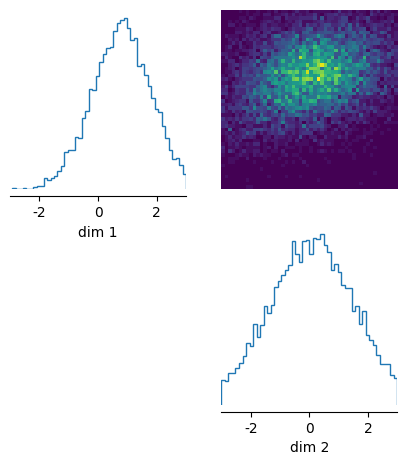

In [47]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(5, 5)
)

# so what works: simulator outputs a batch dimension as the first argument, and the input dimensions are 6000, 100 GRU units and 1 layer! and with batch_first=False for some reason...

## Now try to make it handle 6 dimensions, batch_size = 1, 6, 1000

In [161]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
        [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
        ...,
        [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
        [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
        [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]])

In [148]:
true_data.shape

torch.Size([1000, 6])

In [149]:
true_data.size(0)

1000

In [163]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size: Tuple, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

     
    def forward(self, x):                               #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, _ = self.gru(
            x, h)
        output = self.linear(self.tanh(gru_out[:, -1, :]))
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


 We don't need the init_hidden...

In [164]:
# set prior distribution for the parameters
num_dim = 2
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [165]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [166]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [167]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 157 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

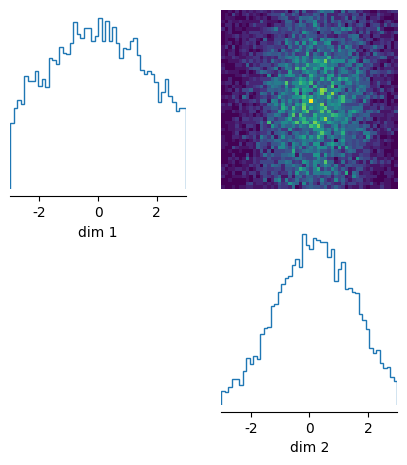

In [168]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(5, 5)
)

# This works, handles 6 dimensions!

# Now try 6 trajectories

In [146]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6


def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[  0.0000,   8.9123,  13.8703,  ...,  46.9959,  42.7398,  38.8630],
        [  1.0000,   1.3648,   2.3506,  ..., 113.7526, 107.1846, 100.8554],
        [  0.0000,  12.9051,  14.4150,  ...,  56.8882,  63.3755,  70.3635],
        [  3.0000,   3.4811,   4.4862,  ...,  25.9989,  29.2513,  32.8362],
        [  0.0000,  42.9083,  61.6269,  ...,   1.2610,   1.2439,   1.2295],
        [  2.0000,   4.0501,   8.8289,  ...,   2.7314,   2.5905,   2.4615]])

In [103]:
true_data.shape

torch.Size([6, 1000])

In [105]:
true_data.size(0)


6

In [106]:
true_data.size(-1)

1000

In [107]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size: Tuple, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()
        self.tanh = nn.Tanh()

    def init_hidden(self):
        # Initialize hidden state
        return torch.zeros(1, 6, self.hidden_size) #The middle value needs to be input.size(0), which is the batch size!
                                                    #The first value is just n_layers and since unidirectional, stays at 1
    def forward(self, x):
        h = torch.zeros(1, 6, self.hidden_size) #The middle value needs to be input.size(0)
        gru_out, _ = self.gru(
            x, h)
        output = self.linear(self.tanh(gru_out[:, -1, :]))
        return output

# Example usage
input_size = 1000 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [108]:
# set prior distribution for the parameters
num_dim = 2
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


In [109]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [110]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [111]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 186 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

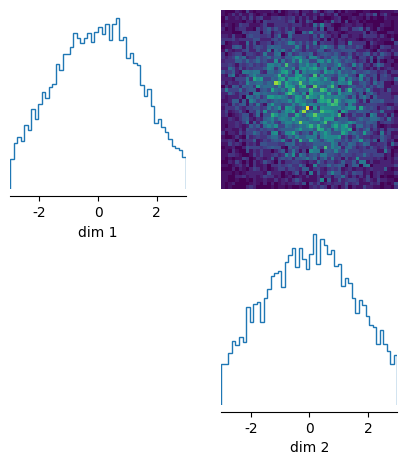

In [112]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(5, 5)
)

# Try to change batch size, specify it, not just infer from the dimensionality of the data (before, we were just obtaining batch_size from input_size[1])  (actually, it does not work, batch size must be of 1! specified by sbi...)

In [114]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
        [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
        ...,
        [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
        [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
        [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]])

In [115]:
true_data.shape

torch.Size([1000, 6])

In [116]:
true_data.size(0)

1000

In [143]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size: Tuple, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = input_size * 6
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()
        self.tanh = nn.Tanh()

    def init_hidden(self):
        # Initialize hidden state
        return torch.zeros(1, self.batch_size, self.hidden_size) #The middle value needs to be the length, in this case 1000, or input.size(0)

    def forward(self, x): #PREPARE FOR SBI ADDS A BATCH DIMENSION TO X, SO IT IS SIZE 1, 1000, 6
        # x must be of shape (batch_size, seq_len, input_size)
        xb = x.view(self.batch_size, x.size(1), self.input_size).double()
        h = torch.zeros(1, self.batch_size, self.hidden_size).double()
        gru_out, _ = self.gru(
            xb, h)
        output = self.linear(self.tanh(gru_out[:, -1, :]))
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [118]:
# set prior distribution for the parameters
num_dim = 2
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


In [144]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [120]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [145]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

RuntimeError: shape '[36, 1000, 6]' is invalid for input of size 6000

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

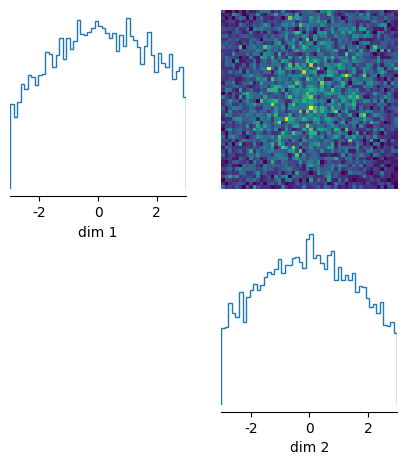

In [ ]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(5, 5)
)

## What is going on with batch_first? prepare_for_sbi adds a batch dimension of 1, but if we specify batch_first=False the batch dimensionw will be input.size(1), which is 1000 if we have the classic 1000x6 data shape.

# What is the dimensionality of the output of a RNN?

In [177]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
        [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
        ...,
        [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
        [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
        [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]])

In [ ]:
true_data.shape

torch.Size([1000, 6])

In [ ]:
true_data.size(0)

1000

In [176]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size: Tuple, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
                                                         #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)- WE KNOW THIS BECAUSE IF WE SAY BATCH_FIRST = FALSE WE GET THAT THE INPUT IS 1,1000,6
    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, _ = self.gru(
            x, h) 
        output = self.linear(self.tanh(gru_out[:, -1, :]))
        embed = torch.mean(output, dim=0) #Pooling, reduce dimension to 1x25 ???
        return embed

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [178]:
# set prior distribution for the parameters
num_dim = 2
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


In [179]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [180]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [181]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

ValueError: Number of input items must be equal to number of context items.

Cannot do 1x25 embeddings?

## It seems that the batch size is not specified as it is the second element of the shape of the input vector: 1, 1000, 6, so batch size would be 1000

# Now what if we include hn??? Don't we need it?